## Лабораторная работа №6. 
Применение сверточных нейронных сетей (многоклассовая классификация)
#### Данные: 
Набор данных для распознавания языка жестов, который состоит из изображений размерности 28x28 в оттенках серого (значение пикселя от 0 до 255). Каждое из изображений обозначает букву латинского алфавита, обозначенную с помощью жеста, как показано на рисунке ниже (рисунок цветной, а изображения в наборе данных в оттенках серого). Обучающая выборка включает в себя 27,455 изображений, а контрольная выборка содержит 7172 изображения. Данные в виде csv-файлов можно скачать на сайте Kaggle -> https://www.kaggle.com/datamunge/sign-language-mnist
#### Ход выполнения:


Скачаем данные с сайта Kaggle и отобразим картунку языка жестов. 

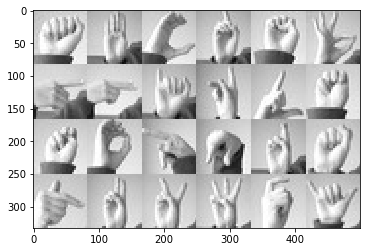

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread("./input/amer_sign3.png")
imgplot = plt.imshow(img)
plt.show()

###### Задание 1.
Загрузите данные. Разделите исходный набор данных на обучающую и валидационную выборки.

Загрузим данные из sign_mnist_train.csv файла. Проверим, что количество маркеров данных равно 24, что соответствует набору букв английского алфавита.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

IMAGE_WIDTH=28
IMAGE_HEIGHT=28
batch_size=32

def read_csv_data(filename):
    data = pd.read_csv(filename)
    data.head()
    labels = np.array(data['label'])
    data.drop('label', axis = 1, inplace = True)
    data = np.array(data.values)

    print("Data shapes:", data.shape, labels.shape, "Classes: ", len(np.unique(labels)))
    return data, labels


x_train, y_train = read_csv_data('./input/sign_mnist_train.csv')

Data shapes: (27455, 784) (27455,) Classes:  24


In [3]:
classes = len(np.unique(y_train))
print(np.unique(y_train))

x_train = x_train.reshape((-1, IMAGE_WIDTH, IMAGE_HEIGHT, 1))
y = np.zeros((np.shape(y_train)[0], classes))
y_train[y_train > 8] = y_train[y_train > 8] - 1

[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


Переведем маркеры в формат one-hot.

In [4]:
from sklearn.preprocessing import LabelBinarizer

def one_hot(labels):
    label_binarizer = LabelBinarizer()
    one_hot_labels = label_binarizer.fit_transform(labels)
    print(one_hot_labels)
    return one_hot_labels


y_train = one_hot(y_train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


Разделим данные на обучающую и валидационную выборки.

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 101)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(21964, 28, 28, 1) (21964, 24) (5491, 28, 28, 1) (5491, 24)


###### Задание 2.
Реализуйте глубокую нейронную сеть со сверточными слоями. Какое качество классификации получено? Какая архитектура сети была использована?

Используем архитектуру LeNet-5, которая представляет собой сеть с несколькими сверточными слоями с чередованием пулинга со средней функцией, а также с полносвязанными слоями для вывода результата сети.

In [6]:
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, SpatialDropout2D, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(Conv2D(6, kernel_size=(5,5), strides=1,input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,1), activation="tanh"))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(16, kernel_size=(5,5), strides=1, activation="tanh"))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(120,activation="tanh"))
model.add(Dense(84,activation="tanh"))
model.add(Dense(classes, activation="softmax"))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               30840     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

###### Задание 3.
Примените дополнение данных (data augmentation). Как это повлияло на качество классификатора?

Применим дополнение данных (data augmentation), чтобы увеличить количество обучающих данных.

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=10,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   shear_range=0.1,
                                   zoom_range=0.075)

train_generator = train_datagen.flow(x=x_train,
                                     y=y_train,
                                     batch_size=batch_size,
                                     shuffle=True)

test_datagen = ImageDataGenerator(rescale=1./255)

val_generator = test_datagen.flow(x=x_val,
                                    y=y_val,
                                    batch_size=batch_size,
                                    shuffle=True)

In [8]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

steps_per_epoch = int(len(y_train)/batch_size)
epochs = 20
history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=steps_per_epoch,
                                validation_data=val_generator,
                                validation_steps=50,
                                epochs=epochs,
                                verbose=2)

Epoch 1/20
686/686 - 23s - loss: 2.8239 - accuracy: 0.1926 - val_loss: 2.2171 - val_accuracy: 0.3425
Epoch 2/20
686/686 - 24s - loss: 1.9937 - accuracy: 0.4235 - val_loss: 1.6396 - val_accuracy: 0.5362
Epoch 3/20
686/686 - 23s - loss: 1.6136 - accuracy: 0.5235 - val_loss: 1.2981 - val_accuracy: 0.6363
Epoch 4/20
686/686 - 24s - loss: 1.3713 - accuracy: 0.5968 - val_loss: 1.0788 - val_accuracy: 0.7000
Epoch 5/20
686/686 - 24s - loss: 1.2005 - accuracy: 0.6376 - val_loss: 0.8926 - val_accuracy: 0.7656
Epoch 6/20
686/686 - 24s - loss: 1.0517 - accuracy: 0.6876 - val_loss: 0.7564 - val_accuracy: 0.8056
Epoch 7/20
686/686 - 24s - loss: 0.9317 - accuracy: 0.7231 - val_loss: 0.6451 - val_accuracy: 0.8456
Epoch 8/20
686/686 - 23s - loss: 0.8383 - accuracy: 0.7533 - val_loss: 0.5557 - val_accuracy: 0.8669
Epoch 9/20
686/686 - 24s - loss: 0.7531 - accuracy: 0.7815 - val_loss: 0.4868 - val_accuracy: 0.8919
Epoch 10/20
686/686 - 24s - loss: 0.6757 - accuracy: 0.8053 - val_loss: 0.4318 - val_accura

Отобразим графики точности обучения и потерь.

In [ ]:
def plot_history(history):
    plt.figure(figsize=(15, 8))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title("Accuracy", fontsize=28)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.legend(['Train','Validation'], fontsize=18)
    plt.show()

    
plot_history(history)    

После обучения модель дает результат точности в 93.1%.

Загрузим тестовый набор данных и приведем к формату модели.

In [10]:
x_test = pd.read_csv('./input/sign_mnist_test.csv')
y_test = x_test['label']
x_test.head()

x_test.drop('label', axis = 1, inplace = True)
x_test = np.array(x_test.values)
x_test = x_test / 255.

x_test = x_test.reshape((-1, IMAGE_WIDTH, IMAGE_HEIGHT, 1))

In [11]:
print(np.unique(y_test))

x_test = x_test.reshape((-1, IMAGE_WIDTH, IMAGE_HEIGHT, 1))
y_test[y_test > 8] = y_test[y_test > 8] - 1

y_test = one_hot(y_test)

[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


Проверим качество модели на тестовой выборке.

In [12]:
y_pred = model.predict(x_test)

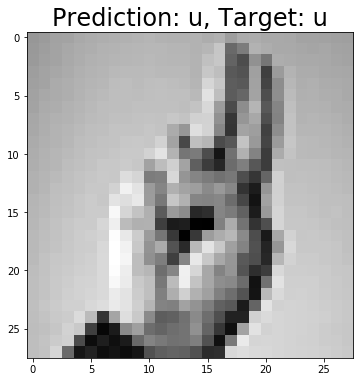

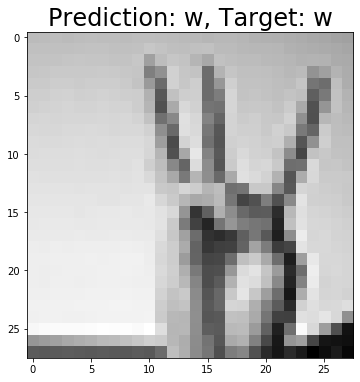

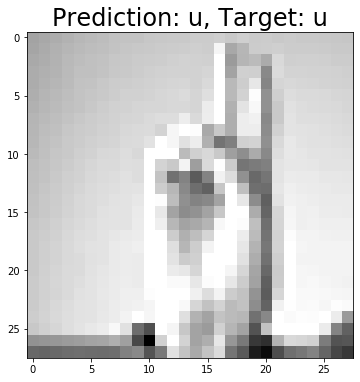

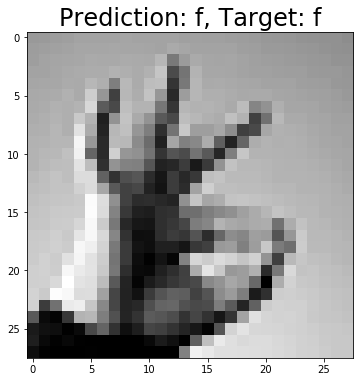

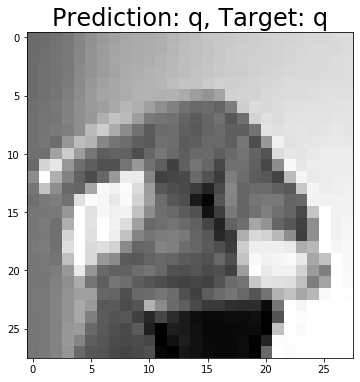

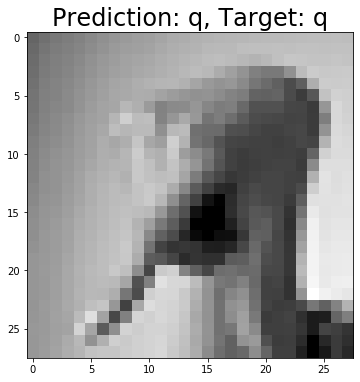

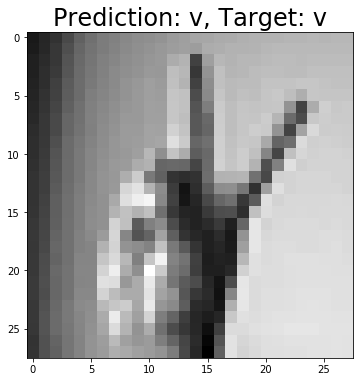

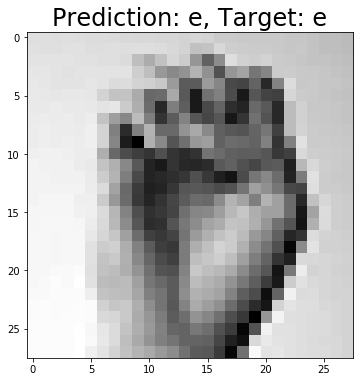

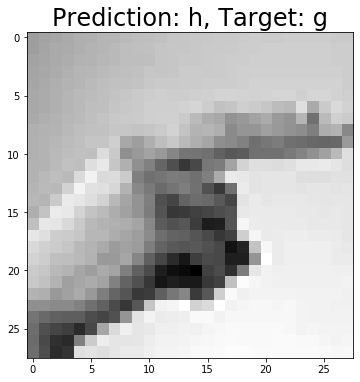

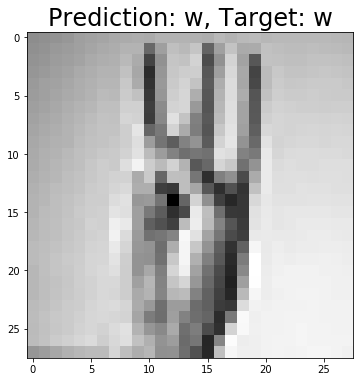

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred.round())


def imshow_w_labels(img, target, pred):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap="gray")
    plt.title("Prediction: %s, Target: %s" % (target, pred), fontsize=24)
    plt.show()


letters = {}
counter = 0
for letter in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v',
               'w', 'x', 'y']:
    letters[counter] = letter
    counter += 1

for kk in range(50, 60):
    imshow_w_labels(x_test[kk, :, :, 0], letters[y_test[kk].argmax()], letters[y_pred[kk].argmax()])

Модель способна распознавать большинство знаков.

###### Задание 4.
Поэкспериментируйте с готовыми нейронными сетями (например, AlexNet, VGG16, Inception и т.п.), применив передаточное обучение. Как это повлияло на качество классификатора? Можно ли было обойтись без него?
Какой максимальный результат удалось получить на контрольной выборке?

Используем модель VGG16 с передаточным обучение.

In [14]:
train = pd.read_csv('./input/sign_mnist_train.csv')
labels = train['label'].values
unique_val = np.array(labels)
np.unique(unique_val)
train.drop('label', axis = 1, inplace = True)

images = train.values
images = np.array([np.reshape(i, (28, 28)) for i in images])
images = np.array([i.flatten() for i in images])

labels = one_hot(labels)

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.3, random_state = 101)

x_train = x_train / 255
x_test = x_test / 255

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


Подготовим данные для модели VGG16. Изменим формат картинок на 48*48.

In [15]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

x_train_t = np.stack([x_train.reshape(x_train.shape[0],28,28)]*3, axis=3).reshape(x_train.shape[0],28,28,3)
x_test_t = np.stack([x_test.reshape(x_test.shape[0],28,28)]*3, axis=3).reshape(x_test.shape[0],28,28,3)
x_train_t.shape, x_test_t.shape

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train_tt = np.asarray([img_to_array(array_to_img(im, scale=True).resize((48,48))) for im in x_train_t])/225
x_test_tt = np.asarray([img_to_array(array_to_img(im, scale=True).resize((48,48))) for im in x_test_t])/225

In [16]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Dense, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(input_shape=(48,48,3), include_top=False, weights="imagenet")
model = Sequential()

model.add(VGG16(weights='imagenet', include_top=False, pooling = 'avg', input_shape=(48, 48, 3)))

model.add(Dense(24, activation = 'softmax'))

model.layers[0].trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 24)                12312     
Total params: 14,727,000
Trainable params: 12,312
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

history = model.fit(x_train_tt, y_train, validation_data = (x_test_tt, y_test), epochs=epochs, batch_size=batch_size)

Train on 19218 samples, validate on 8237 samples
Epoch 1/20
19218/19218 [==============================] - 338s 18ms/sample - loss: 2.9337 - accuracy: 0.2075 - val_loss: 2.5903 - val_accuracy: 0.4457
Epoch 2/20
19218/19218 [==============================] - 326s 17ms/sample - loss: 2.3359 - accuracy: 0.5738 - val_loss: 2.1180 - val_accuracy: 0.6525
Epoch 3/20
19218/19218 [==============================] - 329s 17ms/sample - loss: 1.9317 - accuracy: 0.6876 - val_loss: 1.7801 - val_accuracy: 0.7182
Epoch 4/20
19218/19218 [==============================] - 310s 16ms/sample - loss: 1.6423 - accuracy: 0.7343 - val_loss: 1.5363 - val_accuracy: 0.7565
Epoch 5/20
19218/19218 [==============================] - 276s 14ms/sample - loss: 1.4295 - accuracy: 0.7690 - val_loss: 1.3541 - val_accuracy: 0.7754
Epoch 6/20
19218/19218 [==============================] - 281s 15ms/sample - loss: 1.2672 - accuracy: 0.7923 - val_loss: 1.2103 - val_accuracy: 0.8010
Epoch 7/20
19218/19218 [=====================

Отобразим графики точности обучения и потерь.

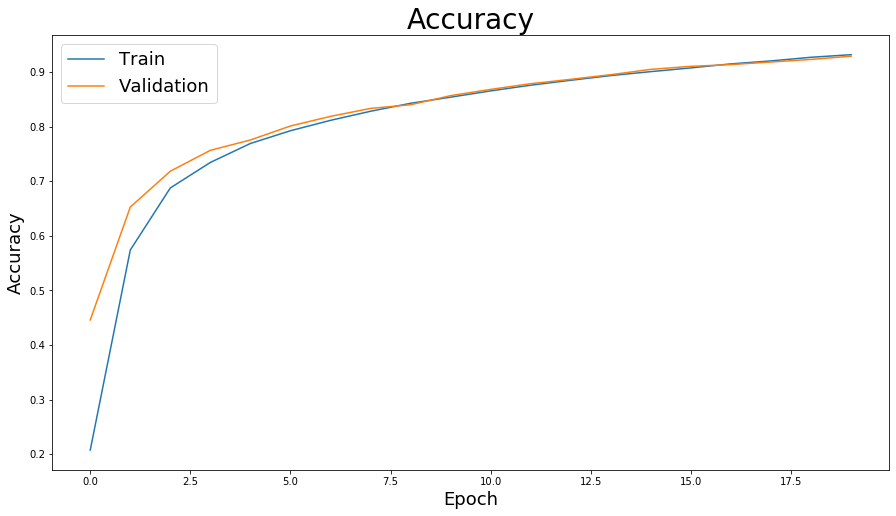

In [18]:
plot_history(history)

Загрузим тестовый набор данных и приведем к формату модели.

In [19]:
x_test = pd.read_csv('./input/sign_mnist_test.csv')
y_test = x_test['label']
x_test.head()
x_test.drop('label', axis = 1, inplace = True)
x_test = np.array(x_test.values)
x_test = x_test / 255.


x_test = x_test.reshape((-1, IMAGE_WIDTH, IMAGE_HEIGHT,1))
y_test = one_hot(y_test)
y_test[y_test>8] = y_test[y_test>8] - 1

test_images_t = np.stack([x_test.reshape(x_test.shape[0], IMAGE_WIDTH, IMAGE_HEIGHT)]*3, axis=3).reshape(x_test.shape[0], IMAGE_WIDTH, IMAGE_HEIGHT, 3)
test_images_tt = np.asarray([img_to_array(array_to_img(im, scale=True).resize((48, 48))) for im in test_images_t])/225

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


Проверим качество модели на тестовой выборке.

In [21]:
y_pred = model.predict(test_images_tt)

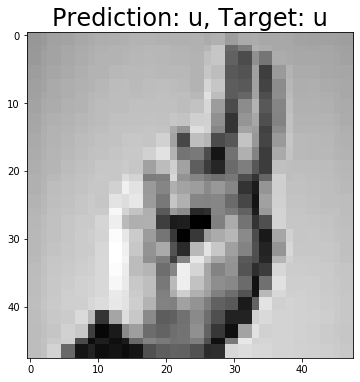

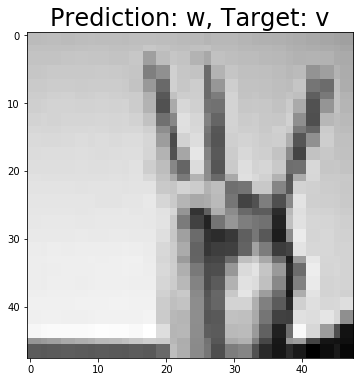

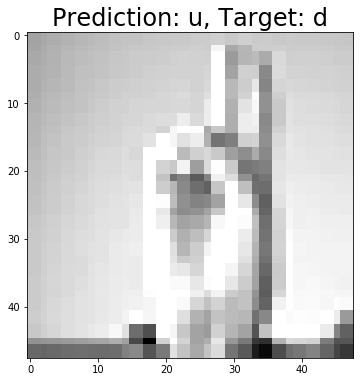

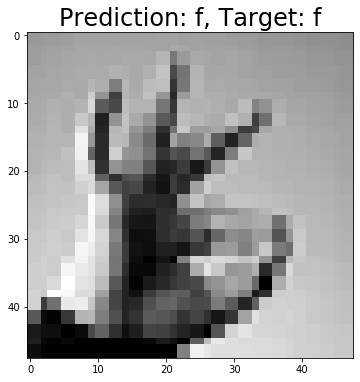

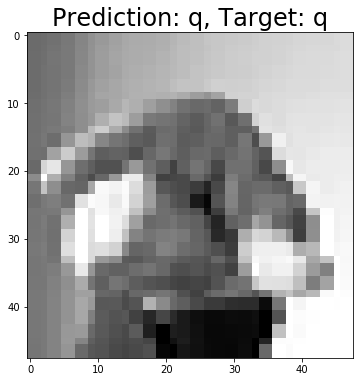

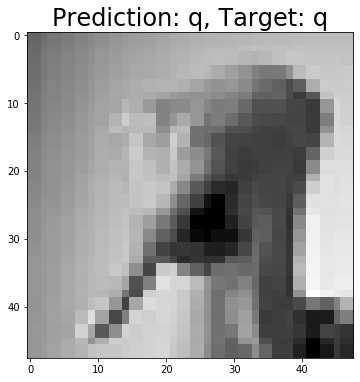

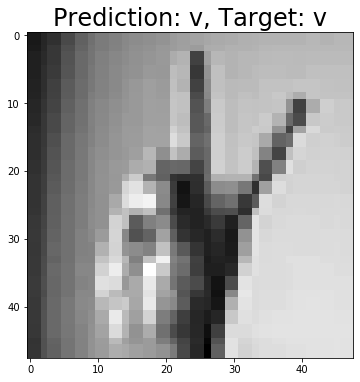

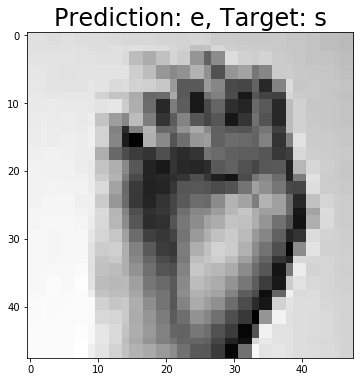

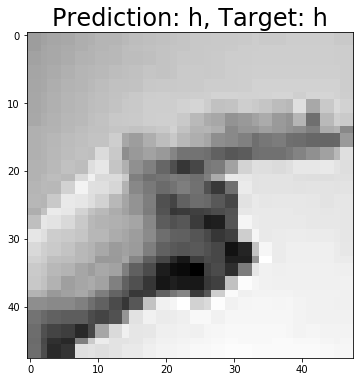

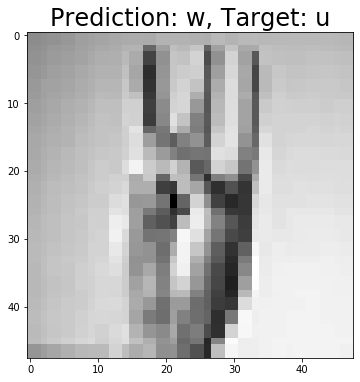

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred.round())

for kk in range(50, 60):
    imshow_w_labels(test_images_tt[kk, :, :, 0], letters[y_test[kk].argmax()], letters[y_pred[kk].argmax()])

Таким образом, модель VGG16 смогла распознать все знаки. При увеличении количества эпох обучения предсказания будут точнее.